# Projet 8

In [1]:
# --- Simple dataset scanner (counts only, no filenames, no JSON) ---
from pathlib import Path
import os
from collections import Counter

# >>> Change this to your dataset root (WSL path) <<<
ROOT = Path("../data")

IGNORE_HIDDEN = True       # ignore .git, __pycache__, etc.
MAX_DIRS_TO_SHOW = 80      # limit directory lines for readability

total_files = 0
total_dirs = 0
by_ext = Counter()
by_dir = {}

for dirpath, dirnames, filenames in os.walk(ROOT):
    # optionally hide hidden/internal dirs
    if IGNORE_HIDDEN:
        dirnames[:] = [d for d in dirnames if not d.startswith(".") and not d.startswith("__")]
    total_dirs += 1
    rel = Path(dirpath).relative_to(ROOT) if Path(dirpath) != ROOT else Path(".")
    by_dir[str(rel)] = len(filenames)
    for fn in filenames:
        by_ext[Path(fn).suffix.lower()] += 1
    total_files += len(filenames)

print(f"[ROOT] {ROOT}")
print(f"dirs={total_dirs:,}  files={total_files:,}\n")

print("By extension (top 10):")
for ext, n in by_ext.most_common(10):
    print(f"  {ext or '(no ext)'}: {n:,}")
print()

print(f"Directory counts (first {MAX_DIRS_TO_SHOW}):")
for i, (rel, n) in enumerate(sorted(by_dir.items())):
    if i >= MAX_DIRS_TO_SHOW:
        print("  ... (truncated)")
        break
    print(f"  {rel}: {n}")

# -------- Cityscapes mini-summary (counts only) --------
def count_pattern(base: Path, split: str, suffix: str) -> int:
    split_dir = base / split
    total = 0
    if split_dir.exists():
        for city_dir in split_dir.iterdir():
            if city_dir.is_dir():
                total += sum(1 for p in city_dir.iterdir()
                             if p.is_file() and p.name.endswith(suffix))
    return total

print("\n[Cityscapes summary]")
for split in ("train", "val", "test"):
    gt_base = ROOT / "gtFine"
    left_base = ROOT / "leftImg8bit"
    label = count_pattern(gt_base, split, "_gtFine_labelIds.png")
    color = count_pattern(gt_base, split, "_gtFine_color.png")
    inst  = count_pattern(gt_base, split, "_gtFine_instanceIds.png")
    poly  = count_pattern(gt_base, split, "_gtFine_polygons.json")
    left  = count_pattern(left_base, split, "_leftImg8bit.png")
    print(f"  {split:5s}: leftImg8bit={left:6d}  labelIds={label:6d}  color={color:6d}  instanceIds={inst:6d}  polygons.json={poly:6d}")


[ROOT] ../data
dirs=63  files=25,000

By extension (top 10):
  .png: 20,000
  .json: 5,000

Directory counts (first 80):
  .: 0
  gtFine: 0
  gtFine/test: 0
  gtFine/test/berlin: 2176
  gtFine/test/bielefeld: 724
  gtFine/test/bonn: 184
  gtFine/test/leverkusen: 232
  gtFine/test/mainz: 1192
  gtFine/test/munich: 1592
  gtFine/train: 0
  gtFine/train/aachen: 696
  gtFine/train/bochum: 384
  gtFine/train/bremen: 1264
  gtFine/train/cologne: 616
  gtFine/train/darmstadt: 340
  gtFine/train/dusseldorf: 884
  gtFine/train/erfurt: 436
  gtFine/train/hamburg: 992
  gtFine/train/hanover: 784
  gtFine/train/jena: 476
  gtFine/train/krefeld: 396
  gtFine/train/monchengladbach: 376
  gtFine/train/strasbourg: 1460
  gtFine/train/stuttgart: 784
  gtFine/train/tubingen: 576
  gtFine/train/ulm: 380
  gtFine/train/weimar: 568
  gtFine/train/zurich: 488
  gtFine/val: 0
  gtFine/val/frankfurt: 1068
  gtFine/val/lindau: 236
  gtFine/val/munster: 696
  leftImg8bit: 0
  leftImg8bit/test: 0
  leftImg8bit/t

In [2]:
from pathlib import Path

ROOT = Path("../data")  # adapte si besoin
SUF_LEFT = "_leftImg8bit.png"
SUF_LBL  = "_gtFine_labelIds.png"

def base_id(name: str) -> str:
    return name[:-len(SUF_LEFT)] if name.endswith(SUF_LEFT) else name[:-len(SUF_LBL)]

def split_counts(split: str):
    left_dir = ROOT / "leftImg8bit" / split
    lbl_dir  = ROOT / "gtFine"      / split
    left = sorted(left_dir.rglob(f"*{SUF_LEFT}")) if left_dir.exists() else []
    lbl  = sorted(lbl_dir.rglob (f"*{SUF_LBL}" )) if lbl_dir.exists()  else []
    left_ids = {base_id(p.name) for p in left}
    lbl_ids  = {base_id(p.name) for p in lbl}
    paired = left_ids & lbl_ids
    print(f"{split:<5} | left={len(left):4d}  labels={len(lbl):4d}  paired={len(paired):4d}")

for sp in ("train", "val", "test"):
    split_counts(sp)



train | left=2975  labels=2975  paired=2975
val   | left= 500  labels= 500  paired= 500
test  | left=1525  labels=1525  paired=1525


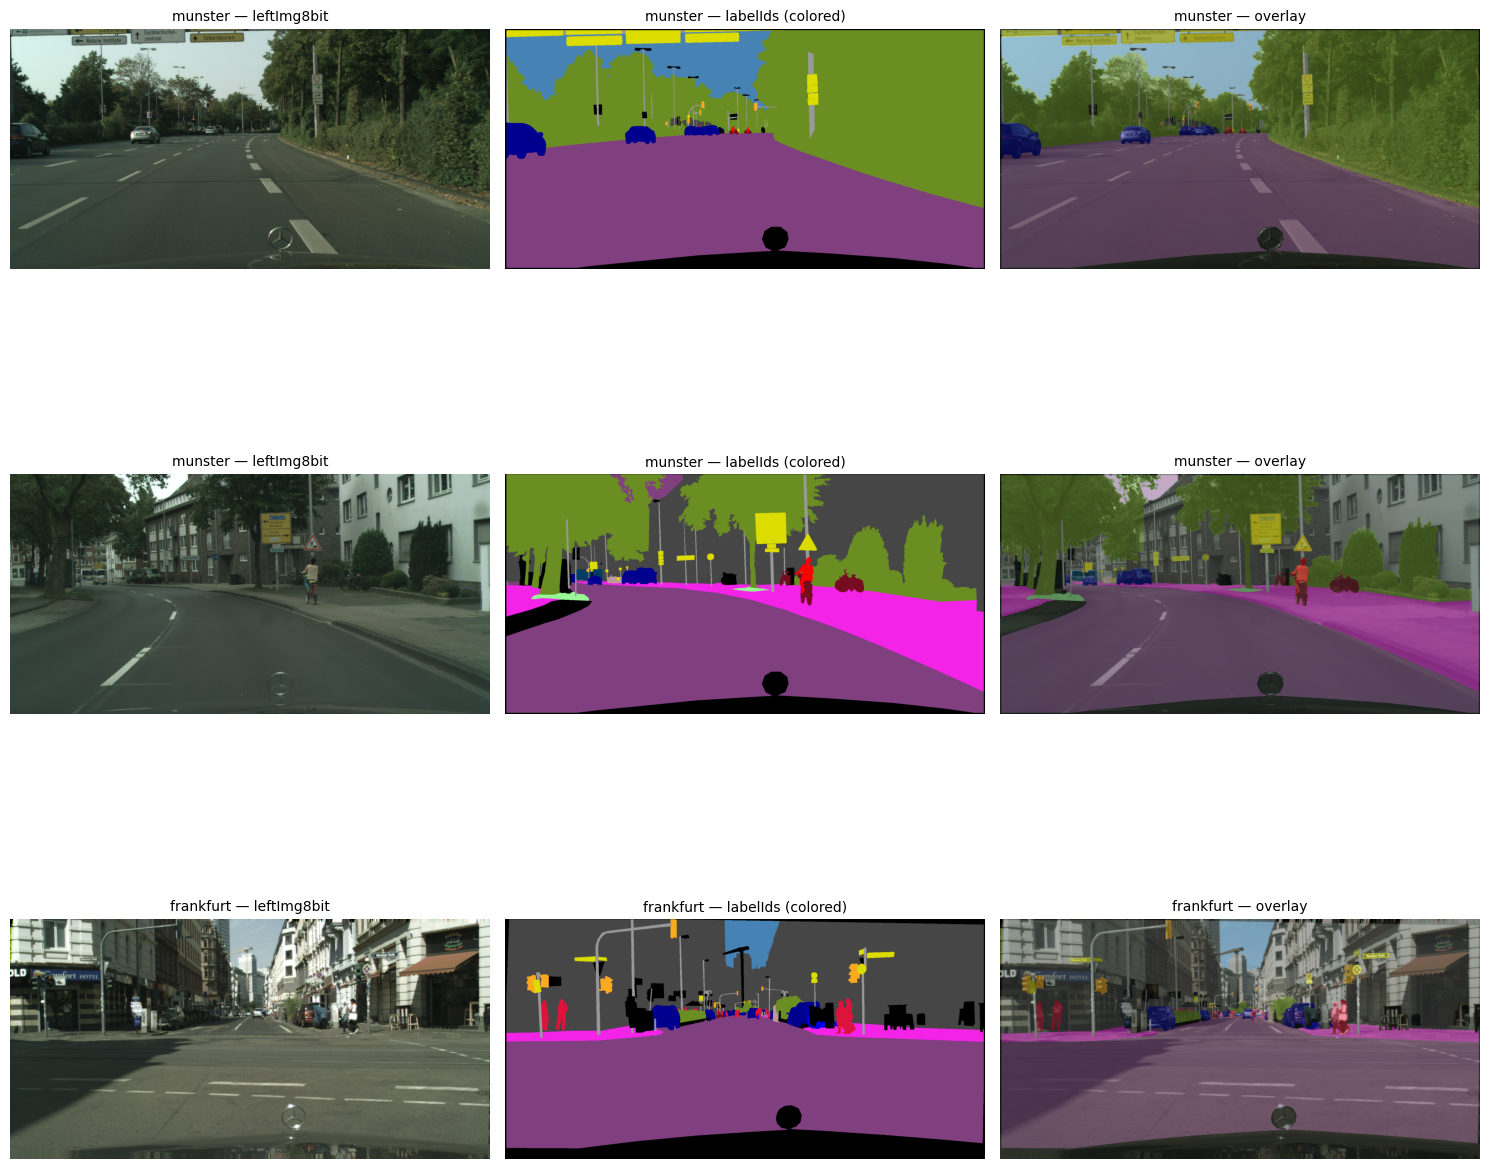

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

ROOT = Path("../data")

PALETTE = {
    7:(128,64,128), 8:(244,35,232), 11:(70,70,70), 12:(102,102,156), 13:(190,153,153),
    17:(153,153,153), 19:(250,170,30), 20:(220,220,0), 21:(107,142,35), 22:(152,251,152),
    23:(70,130,180), 24:(220,20,60), 25:(255,0,0), 26:(0,0,142), 27:(0,0,70),
    28:(0,60,100), 31:(0,80,100), 32:(0,0,230), 33:(119,11,32),
}

def pairs(split="val"):
    lbls = sorted((ROOT/"gtFine"/split).rglob("*_gtFine_labelIds.png"))
    out = []
    for lp in lbls:
        stem = lp.name.replace("_gtFine_labelIds.png", "")
        city = lp.parent.name
        left = ROOT/"leftImg8bit"/split/city/(stem+"_leftImg8bit.png")
        if left.exists():
            out.append((left, lp))
    return out

def colorize(ids: np.ndarray) -> Image.Image:
    h, w = ids.shape
    rgb = np.zeros((h, w, 3), np.uint8)
    for k, c in PALETTE.items():
        rgb[ids == k] = c
    return Image.fromarray(rgb, "RGB")

def overlay(img: Image.Image, mask_rgb: Image.Image, alpha=0.5) -> Image.Image:
    a = np.asarray(img.convert("RGB"), np.float32)
    b = np.asarray(mask_rgb, np.float32)
    return Image.fromarray(np.clip((1-alpha)*a + alpha*b, 0, 255).astype(np.uint8))

samples = pairs("val")
assert samples, "No pairs found — check your paths."
random.shuffle(samples)
k = 3

plt.figure(figsize=(15, 5*k))
for i, (left_p, lbl_p) in enumerate(samples[:k]):
    left = Image.open(left_p).convert("RGB")
    ids  = np.array(Image.open(lbl_p))
    mask = colorize(ids)
    over = overlay(left, mask, alpha=0.45)
    for j, (img, title) in enumerate([(left,"leftImg8bit"),(mask,"labelIds (colored)"),(over,"overlay")]):
        ax = plt.subplot(k, 3, i*3 + j + 1)
        ax.imshow(img); ax.set_title(f"{left_p.parent.name} — {title}", fontsize=10); ax.axis("off")
plt.tight_layout(); plt.show()



### Remapping Cityscapes 32→8 classes

Vérifier la balance des classes !!!!


In [4]:
# --- 32→8 mapping (Cityscapes labelIds -> 8-class IDs), ignore = 255 ---
import numpy as np

CS_LABELID_TO_8 = {
    # 0..5 (voids) -> ignore by LUT fill (no need to list)
    6: 0,
    7: 0,  9: 0, 10: 0,           # road-like: road, parking, rail track
    8: 1,                         # sidewalk
    11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,   # building + barriers
    17: 3, 18: 3, 19: 3, 20: 3,                 # traffic objs (pole/ts/tl)
    21: 4, 22: 4,                                 # vegetation + terrain
    23: 5,                                       # sky
    24: 6, 25: 6,                                 # person + rider
    26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7, 32: 7, 33: 7,  # vehicles
}

def build_labelid_to8_lut(ignore_value: int = 255) -> np.ndarray:
    """Create a 256-entry LUT mapping Cityscapes labelIds -> {0..7} or 255(ignore)."""
    lut = np.full(256, ignore_value, dtype=np.uint8)
    for k, v in CS_LABELID_TO_8.items():
        lut[k] = v
    return lut

LUT_32TO8 = build_labelid_to8_lut(ignore_value=255)

def remap_labelids_to8(arr_uint16: np.ndarray) -> np.ndarray:
    """Vectorized remap of HxW labelIds (uint16/uint8) to 8-class IDs with 255 ignore."""
    arr = arr_uint16.astype(np.uint16)
    arr = np.minimum(arr, 255).astype(np.uint8)
    return LUT_32TO8[arr]


In [5]:
PALETTE_8 = {
    0:(128,64,128),   # road
    1:(244,35,232),   # sidewalk
    2:(70,70,70),     # building+barrier
    3:(220,220,0),    # traffic objs
    4:(107,142,35),   # vegetation/terrain
    5:(70,130,180),   # sky
    6:(220,20,60),    # person+rider
    7:(0,0,142),      # vehicle
}


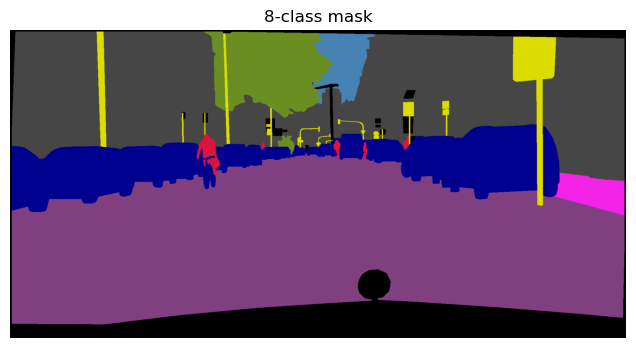

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def colorize_8(label8: np.ndarray, palette: dict) -> Image.Image:
    h, w = label8.shape
    rgb = np.zeros((h, w, 3), np.uint8)
    for k, c in palette.items():
        rgb[label8 == k] = c
    return Image.fromarray(rgb, "RGB")

sample_lbl = next(Path("../data/gtFine/val/frankfurt").glob("*_gtFine_labelIds.png"))
arr = np.array(Image.open(sample_lbl))
arr8 = remap_labelids_to8(arr)
plt.figure(figsize=(8,4)); plt.imshow(colorize_8(arr8, PALETTE_8)); plt.axis("off"); plt.title("8-class mask"); plt.show()


In [7]:
import os

# ↓↓↓ Quieter TensorFlow logs (set BEFORE importing tf)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"     # 0=all, 1=INFO off, 2=INFO+WARNING off, 3=all off
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"  # avoid grabbing all GPU memory
# Optional: disable oneDNN (removes the "oneDNN custom ops are on" line, and tiny numeric diffs)
# os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
from absl import logging as absl_logging
absl_logging.set_verbosity(absl_logging.ERROR)  # reduce absl spam

# (Optional) confirm GPU + set memory growth (extra safety)
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

print("TF:", tf.__version__, "| GPUs:", gpus)

# ==========================
# Cityscapes 32→8 remapping
# ==========================
import numpy as np

# 8 classes for embedded use (ignore=255):
# 0=road (7,9,10) | 1=sidewalk(8) | 2=building+barriers(11–16) | 3=traffic objs(17–20)
# 4=vegetation+terrain(21,22) | 5=sky(23) | 6=person+rider(24,25) | 7=vehicle(26–33)
CS_LABELID_TO_8 = {
    6:0,
    7:0, 9:0, 10:0,
    8:1,
    11:2, 12:2, 13:2, 14:2, 15:2, 16:2,
    17:3, 18:3, 19:3, 20:3,
    21:4, 22:4,
    23:5,
    24:6, 25:6,
    26:7, 27:7, 28:7, 29:7, 30:7, 31:7, 32:7, 33:7,
}

def build_labelid_to8_lut(ignore_value: int = 255) -> np.ndarray:
    lut = np.full(256, ignore_value, dtype=np.uint8)
    for k, v in CS_LABELID_TO_8.items():
        lut[k] = v
    return lut

LUT_32TO8 = build_labelid_to8_lut(ignore_value=255)
LUT_TF = tf.convert_to_tensor(LUT_32TO8, dtype=tf.uint8)  # shape [256]

# ===================
# Dataset (tf.data)
# ===================
from pathlib import Path
ROOT = Path("../data")               # <<< change if needed (WSL path)
INPUT_SIZE = (512, 1024)             # (H, W)
BATCH_SIZE = 4

SUF_LEFT = "_leftImg8bit.png"
SUF_LBL  = "_gtFine_labelIds.png"

def list_pairs(split: str):
    """Return two aligned lists: left paths and label paths for a given split."""
    lefts, labels = [], []
    lbl_root = ROOT / "gtFine" / split
    for lbl in sorted(lbl_root.rglob(f"*{SUF_LBL}")):
        city = lbl.parent.name
        stem = lbl.name.replace(SUF_LBL, "")
        left = ROOT / "leftImg8bit" / split / city / f"{stem}{SUF_LEFT}"
        if left.exists():
            lefts.append(str(left))
            labels.append(str(lbl))
    if not lefts:
        raise FileNotFoundError(f"No pairs found for split='{split}'. Check your paths under {ROOT}.")
    return lefts, labels

def decode_and_preprocess(left_path, lbl_path, training: bool):
    # 1) Read bytes
    left_bytes = tf.io.read_file(left_path)
    lbl_bytes  = tf.io.read_file(lbl_path)

    # 2) Decode
    img = tf.io.decode_png(left_bytes, channels=3)     # uint8 [H,W,3]
    lab = tf.io.decode_png(lbl_bytes,  channels=1)     # uint8/16 [H,W,1]

    # 3) To workable dtypes
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    lab = tf.cast(lab, tf.int32)                          # index dtype for LUT

    # 4) Remap 32→8 via LUT
    lab_clipped = tf.minimum(lab, 255)
    lab8 = tf.gather(LUT_TF, lab_clipped)                 # uint8 [H,W,1]
    lab8 = tf.squeeze(lab8, axis=-1)                      # uint8 [H,W]

    # 5) Simple augment (sync flip)
    if training:
        do_flip = tf.random.uniform(()) > 0.5
        img  = tf.cond(do_flip, lambda: tf.image.flip_left_right(img), lambda: img)
        lab8 = tf.cond(do_flip, lambda: tf.image.flip_left_right(lab8[..., None])[:, :, 0], lambda: lab8)

    # 6) Resize (labels in nearest, keep uint8)
    img  = tf.image.resize(img,  INPUT_SIZE, method="bilinear")
    lab8 = tf.cast(tf.image.resize(lab8[..., None], INPUT_SIZE, method="nearest")[:, :, 0], tf.uint8)

    # 7) Ignore handling → sample_weight (float32); labels safe (uint8→int32)
    ignore_val = tf.constant(255, dtype=tf.uint8)
    ignore = tf.equal(lab8, ignore_val)  # bool [H,W]

    weights = tf.where(ignore,
                       tf.zeros_like(lab8, dtype=tf.float32),
                       tf.ones_like(lab8,  dtype=tf.float32))              # float32 [H,W]

    lab8_safe = tf.where(ignore,
                         tf.zeros_like(lab8),   # uint8 0 (will be masked by weights anyway)
                         lab8)
    labels = tf.cast(lab8_safe, tf.int32)                                    # int32 [H,W]

    return img, labels, weights

def make_dataset(split: str, batch_size: int = BATCH_SIZE, training: bool = True) -> tf.data.Dataset:
    lefts, labels = list_pairs(split)
    ds = tf.data.Dataset.from_tensor_slices((lefts, labels))
    if training:
        ds = ds.shuffle(buffer_size=min(len(lefts), 2000), reshuffle_each_iteration=True)
    ds = ds.map(lambda l, y: decode_and_preprocess(l, y, training),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=training)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# ==============
# Smoke test
# ==============
train_ds = make_dataset("train", batch_size=2, training=True)
xb, yb, wb = next(iter(train_ds))
print("x:", xb.shape, xb.dtype, "| y:", yb.shape, yb.dtype, "| w:", wb.shape, wb.dtype)

# Example compile/fit (model must output logits with 8 channels)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# opt  = tf.keras.optimizers.Adam(1e-3)
# model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
# model.fit(train_ds,
#           validation_data=make_dataset("val", batch_size=2, training=False),
#           epochs=1)


2025-10-04 11:01:11.505940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759568471.575271 2157767 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759568471.597815 2157767 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759568471.766327 2157767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759568471.766358 2157767 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759568471.766359 2157767 computation_placer.cc:177] computation placer alr

TF: 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1759568477.423656 2157767 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


x: (2, 512, 1024, 3) <dtype: 'float32'> | y: (2, 512, 1024) <dtype: 'int32'> | w: (2, 512, 1024) <dtype: 'float32'>


In [8]:
# ==== Class balance for Cityscapes 8 classes (with ignore=255) ====
from pathlib import Path
import numpy as np
from PIL import Image

# ---- Config (adapt if needed) ----
ROOT = Path("../data")          # dataset root (WSL path)
SPLIT = "train"                 # "train" | "val" | "test"
SUF_LBL = "_gtFine_labelIds.png"

# 8-class names (your mapping)
CLASS8_NAMES = [
    "road", "sidewalk", "building+barriers", "traffic-objs",
    "vegetation+terrain", "sky", "person+rider", "vehicle"
]

# If LUT_32TO8 not in scope, (re)build it quickly:
try:
    LUT_32TO8
except NameError:
    CS_LABELID_TO_8 = {
        6:0, 7:0, 9:0, 10:0, 8:1, 11:2,12:2,13:2,14:2,15:2,16:2,
        17:3,18:3,19:3,20:3, 21:4,22:4, 23:5, 24:6,25:6,
        26:7,27:7,28:7,29:7,30:7,31:7,32:7,33:7,
    }
    LUT_32TO8 = np.full(256, 255, dtype=np.uint8)
    for k, v in CS_LABELID_TO_8.items():
        LUT_32TO8[k] = v

def remap_to8_np(arr_label_ids: np.ndarray) -> np.ndarray:
    """arr_label_ids: HxW uint16/uint8 -> HxW uint8 in {0..7,255}"""
    arr = arr_label_ids.astype(np.uint16)
    arr = np.minimum(arr, 255).astype(np.uint8)
    return LUT_32TO8[arr]

def class_balance(split: str = SPLIT):
    lbl_paths = sorted((ROOT/"gtFine"/split).rglob(f"*{SUF_LBL}"))
    assert lbl_paths, f"No labels found under {ROOT}/gtFine/{split}"
    counts = np.zeros(8, dtype=np.int64)
    ignore = 0
    for i, p in enumerate(lbl_paths, 1):
        lab = np.array(Image.open(p))         # (H,W) uint16/uint8
        lab8 = remap_to8_np(lab)              # (H,W) uint8
        m_ignore = (lab8 == 255)
        ignore += int(m_ignore.sum())
        # bincount only on valid pixels
        c = np.bincount(lab8[~m_ignore].ravel(), minlength=8)
        counts += c[:8]
        if i % 500 == 0 or i == len(lbl_paths):
            print(f"[{split}] processed {i}/{len(lbl_paths)} images...", end="\r")
    print()
    total_valid = int(counts.sum())
    total_pixels = total_valid + ignore
    freqs = counts / max(total_valid, 1)
    return counts, ignore, total_valid, total_pixels, freqs

counts, ignore, total_valid, total_pixels, freqs = class_balance("train")

print("\n=== Class balance (train) ===")
for k, (name, n, f) in enumerate(zip(CLASS8_NAMES, counts, freqs)):
    print(f"{k}: {name:<20s}  pixels={n:,}   freq={f:.4%}")
print(f"\nignore pixels (==255): {ignore:,}")
print(f"total valid pixels:     {total_valid:,}")
print(f"total pixels (incl. ignore): {total_pixels:,}")

# ---- Optional: derive class weights ----
# Inverse-frequency, normalized to mean=1 (good starting point)
weights_inv = (1.0 / np.maximum(freqs, 1e-12))
weights_inv = weights_inv / weights_inv.mean()
print("\nSuggested class weights (inverse-freq, mean≈1):")
for k, (name, w) in enumerate(zip(CLASS8_NAMES, weights_inv)):
    print(f"{k}: {name:<20s}  w={w:.3f}")

# Median-frequency balancing (alternative)
median_f = np.median(freqs[freqs > 0])
weights_med = median_f / np.maximum(freqs, 1e-12)
weights_med = weights_med / weights_med.mean()
print("\nSuggested class weights (median-freq, mean≈1):")
for k, (name, w) in enumerate(zip(CLASS8_NAMES, weights_med)):
    print(f"{k}: {name:<20s}  w={w:.3f}")


[train] processed 2975/2975 images...

=== Class balance (train) ===
0: road                  pixels=2,162,350,597   freq=38.1012%
1: sidewalk              pixels=336,090,793   freq=5.9220%
2: building+barriers     pixels=1,367,059,988   freq=24.0880%
3: traffic-objs          pixels=110,214,659   freq=1.9420%
4: vegetation+terrain    pixels=943,733,524   freq=16.6289%
5: sky                   pixels=221,979,646   freq=3.9113%
6: person+rider          pixels=74,789,586   freq=1.3178%
7: vehicle               pixels=459,059,194   freq=8.0888%

ignore pixels (==255): 563,749,213
total valid pixels:     5,675,277,987
total pixels (incl. ignore): 6,239,027,200

Suggested class weights (inverse-freq, mean≈1):
0: road                  w=0.108
1: sidewalk              w=0.693
2: building+barriers     w=0.170
3: traffic-objs          w=2.113
4: vegetation+terrain    w=0.247
5: sky                   w=1.049
6: person+rider          w=3.113
7: vehicle               w=0.507

Suggested class weight

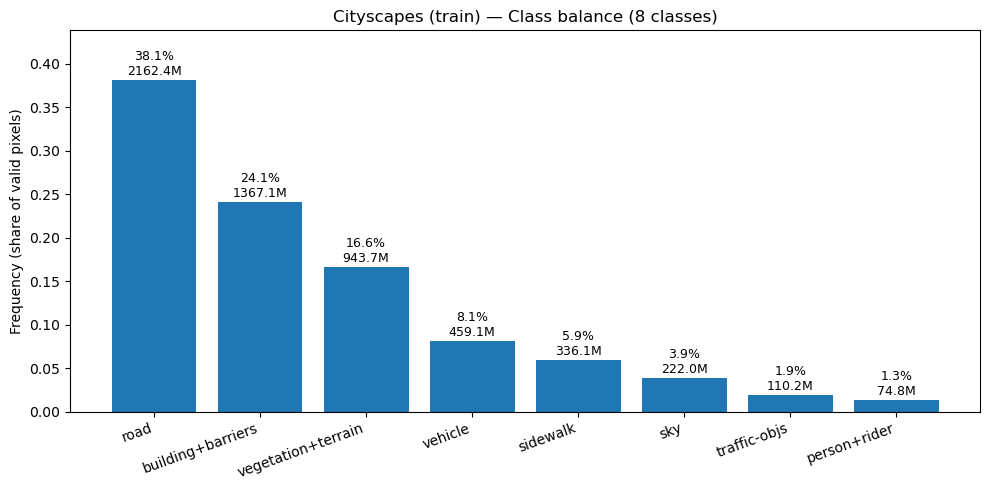

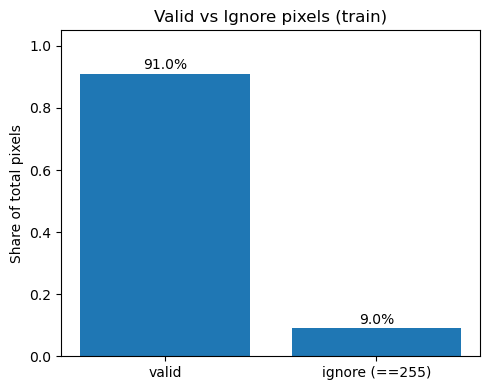

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# expects: counts (np.array shape [8]), freqs (shape [8]), ignore (int),
#          total_valid (int), total_pixels (int), CLASS8_NAMES (list of 8 str)

# ---- 1) Bar chart des 8 classes (trié décroissant) ----
order = np.argsort(freqs)[::-1]
names_sorted = [CLASS8_NAMES[i] for i in order]
freqs_sorted = freqs[order]
counts_sorted = counts[order]

plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(names_sorted)), freqs_sorted)  # no explicit colors
plt.xticks(range(len(names_sorted)), names_sorted, rotation=20, ha="right")
plt.ylabel("Frequency (share of valid pixels)")
plt.title("Cityscapes (train) — Class balance (8 classes)")

# annotations: % + millions de pixels
for i, (b, f, c) in enumerate(zip(bars, freqs_sorted, counts_sorted)):
    plt.text(b.get_x() + b.get_width()/2,
             b.get_height() + 0.002,
             f"{f*100:.1f}%\n{c/1e6:.1f}M",
             ha="center", va="bottom", fontsize=9)

plt.ylim(0, max(freqs_sorted)*1.15)
plt.tight_layout()
plt.show()

# ---- 2) Valid vs Ignore (pour info) ----
valid_share = total_valid / total_pixels
ignore_share = 1.0 - valid_share

plt.figure(figsize=(5, 4))
bars2 = plt.bar([0,1], [valid_share, ignore_share])
plt.xticks([0,1], ["valid", "ignore (==255)"])
plt.ylabel("Share of total pixels")
plt.title("Valid vs Ignore pixels (train)")

for x, v in zip([0,1], [valid_share, ignore_share]):
    plt.text(x, v + 0.005, f"{v*100:.1f}%", ha="center", va="bottom")

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


In [10]:
if False:
    # -*- coding: utf-8 -*-
    """
    Cityscapes -> 8 classes (PALETTE_8), ignore=255
    DeepLabV3+ (ResNet50, ImageNet), TensorFlow/Keras
    + MLflow logging (params/metrics/artifacts)
    + Save best model (.keras) & log to MLflow
    """

    import os, glob, re, shutil, datetime
    from typing import List, Tuple, Optional

    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    # ---------------------- Config ----------------------
    DATA_ROOT = "../data"
    LEFT_DIR  = os.path.join(DATA_ROOT, "leftImg8bit")
    GT_DIR    = os.path.join(DATA_ROOT, "gtFine")

    IMG_SUFFIX = "_leftImg8bit.png"
    LBL_SUFFIX = "_gtFine_labelIds.png"   # we remap labelIds (0..33) ourselves

    SEED = 1337
    NUM_CLASSES = 8                       # matches PALETTE_8 (0..7)
    IGNORE_INDEX = 255
    HEIGHT, WIDTH = 512, 1024
    BATCH_SIZE = 2
    LR = 3e-4
    EPOCHS = 60
    AUTOTUNE = tf.data.AUTOTUNE

    # Ensure deterministic behavior (as much as possible)
    tf.keras.utils.set_random_seed(SEED)
    tf.config.experimental.enable_op_determinism()

    # Optional: force float32 policy (stable numerics)
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("float32")

    print(f"TF: {tf.__version__} | GPUs: {tf.config.list_physical_devices('GPU')}")

    # Optional palette (viz only)
    PALETTE_8 = {
        0:(128, 64,128),  # road
        1:(244, 35,232),  # sidewalk
        2:( 70, 70, 70),  # building+barrier
        3:(220,220,  0),  # traffic objs
        4:(107,142, 35),  # vegetation/terrain
        5:( 70,130,180),  # sky
        6:(220, 20, 60),  # person+rider
        7:(  0,  0,142),  # vehicle
    }

    # ---------------------- Pair listing ----------------------
    def left_to_label_path(left_path: str) -> str:
        parts = left_path.split(os.sep)
        parts[parts.index("leftImg8bit")] = "gtFine"
        parts[-1] = parts[-1].replace(IMG_SUFFIX, LBL_SUFFIX)
        return os.path.join(*parts)

    def gather_pairs(split: str) -> Tuple[List[str], List[str], List[str]]:
        img_glob = os.path.join(LEFT_DIR, split, "*", f"*{IMG_SUFFIX}")
        left_files = sorted(glob.glob(img_glob))
        left_ok, lbl_ok, missing = [], [], []
        for lp in left_files:
            lb = left_to_label_path(lp)
            if os.path.exists(lb):
                left_ok.append(lp)
                lbl_ok.append(lb)
            else:
                missing.append(lb)
        return left_ok, lbl_ok, missing

    def report_pairs(split: str, xs: List[str], ys: List[str], miss: List[str]):
        print(f"[info] {split}: {len(xs)} paires valides | {len(miss)} manquantes")
        if xs:
            print(f"exemple mapping: {xs[0]} -> {ys[0]}")

    # ---------------------- Label remap (Cityscapes 0..33 -> 8 classes + 255) ----------------------
    # 0 road: 7,6,9,10
    # 1 sidewalk: 8
    # 2 building+barrier: 11..16
    # 3 traffic objects: 17..20
    # 4 vegetation/terrain: 21,22
    # 5 sky: 23
    # 6 human: 24,25
    # 7 vehicle: 26..33
    # ignore: 0..5
    REMAP_TABLE = [IGNORE_INDEX] * 34
    for k in [6, 7, 9, 10]: REMAP_TABLE[k] = 0
    REMAP_TABLE[8] = 1
    for k in [11, 12, 13, 14, 15, 16]: REMAP_TABLE[k] = 2
    for k in [17, 18, 19, 20]: REMAP_TABLE[k] = 3
    for k in [21, 22]: REMAP_TABLE[k] = 4
    REMAP_TABLE[23] = 5
    for k in [24, 25]: REMAP_TABLE[k] = 6
    for k in [26, 27, 28, 29, 30, 31, 32, 33]: REMAP_TABLE[k] = 7

    REMAP_LUT = tf.constant(REMAP_TABLE, dtype=tf.int32)

    @tf.function
    def remap_labels(y: tf.Tensor) -> tf.Tensor:
        """Map Cityscapes labelIds (0..33) to {0..7, 255} according to PALETTE_8."""
        y = tf.clip_by_value(y, 0, 33)
        return tf.gather(REMAP_LUT, y)

    # ---------------------- I/O & dataset ----------------------
    def decode_img(path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
        return img

    def decode_lbl(path: tf.Tensor) -> tf.Tensor:
        raw = tf.io.read_file(path)
        y = tf.image.decode_png(raw, channels=1)
        y = tf.squeeze(y, axis=-1)        # [H,W] uint8
        y = tf.cast(y, tf.int32)
        y = remap_labels(y)               # -> {0..7, 255}
        return y

    def resize_pair(x: tf.Tensor, y: tf.Tensor):
        x = tf.image.resize(x, (HEIGHT, WIDTH), method="bilinear")
        y = tf.cast(tf.image.resize(tf.expand_dims(y, -1), (HEIGHT, WIDTH),
                                    method="nearest"), tf.int32)
        y = tf.squeeze(y, axis=-1)
        return x, y

    def augment(x: tf.Tensor, y: tf.Tensor):
        do_flip = tf.less(tf.random.uniform([]), 0.5)
        x = tf.cond(do_flip, lambda: tf.image.flip_left_right(x), lambda: x)
        y = tf.cond(do_flip, lambda: tf.image.flip_left_right(tf.expand_dims(y, -1)),
                    lambda: tf.expand_dims(y, -1))
        y = tf.squeeze(y, -1)
        return x, y

    def make_weights(y: tf.Tensor) -> tf.Tensor:
        # 0 on ignored pixels, 1 otherwise
        return tf.where(tf.equal(y, IGNORE_INDEX), 0.0, 1.0)

    def sanitize_labels_for_loss(y: tf.Tensor) -> tf.Tensor:
        """Replace ignore index (255) by a valid index (0) before sending to loss.
        These pixels have sample_weight=0, so this replacement doesn't affect optimization."""
        return tf.where(tf.equal(y, IGNORE_INDEX), tf.zeros_like(y), y)

    def parse_example(img_path: tf.Tensor, lbl_path: tf.Tensor, training: bool):
        x = decode_img(img_path)
        y = decode_lbl(lbl_path)             # {0..7, 255}
        x, y = resize_pair(x, y)
        if training:
            x, y = augment(x, y)
        w = make_weights(y)                  # 0 where y==255, else 1
        y = sanitize_labels_for_loss(y)      # 255 -> 0 to avoid NaN in sparse CE
        return x, y, w

    def build_dataset(x_paths: List[str], y_paths: List[str], training: bool) -> tf.data.Dataset:
        ds = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
        if training:
            ds = ds.shuffle(buffer_size=len(x_paths), seed=SEED, reshuffle_each_iteration=True)
        ds = ds.map(lambda xp, yp: parse_example(xp, yp, training), num_parallel_calls=AUTOTUNE)
        ds = ds.batch(BATCH_SIZE, drop_remainder=False)
        ds = ds.prefetch(AUTOTUNE)
        return ds

    # ---------------------- Model: ASPP & DeepLabV3+ ----------------------
    def ASPP(x, out_channels=256, rates=(6, 12, 18), name="aspp"):
        h, w = keras.backend.int_shape(x)[1:3]

        img_pool = layers.GlobalAveragePooling2D(keepdims=True, name=f"{name}_imgpool")(x)
        img_pool = layers.Conv2D(out_channels, 1, padding="same", use_bias=False, name=f"{name}_img_1x1")(img_pool)
        img_pool = layers.BatchNormalization(name=f"{name}_img_1x1_bn")(img_pool)
        img_pool = layers.ReLU(name=f"{name}_img_relu")(img_pool)
        img_pool = layers.Resizing(h, w, interpolation="bilinear", name=f"{name}_ups")(img_pool)

        conv_1x1 = layers.Conv2D(out_channels, 1, padding="same", use_bias=False, name=f"{name}_1x1")(x)
        conv_1x1 = layers.BatchNormalization(name=f"{name}_1x1_bn")(conv_1x1)
        conv_1x1 = layers.ReLU(name=f"{name}_1x1_relu")(conv_1x1)

        atrous = []
        for r in rates:
            a = layers.Conv2D(out_channels, 3, padding="same", dilation_rate=r, use_bias=False, name=f"{name}_r{r}")(x)
            a = layers.BatchNormalization(name=f"{name}_r{r}_bn")(a)
            a = layers.ReLU(name=f"{name}_r{r}_relu")(a)
            atrous.append(a)

        x = layers.Concatenate(name=f"{name}_concat")([conv_1x1, *atrous, img_pool])
        x = layers.Conv2D(out_channels, 1, padding="same", use_bias=False, name=f"{name}_proj")(x)
        x = layers.BatchNormalization(name=f"{name}_proj_bn")(x)
        x = layers.ReLU(name=f"{name}_proj_relu")(x)
        x = layers.Dropout(0.1, name=f"{name}_drop")(x)
        return x

    def DeeplabV3Plus_ResNet50(input_shape=(HEIGHT, WIDTH, 3), num_classes=NUM_CLASSES, output_stride=16):
        assert output_stride in (8, 16)
        base = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
        low  = base.get_layer("conv2_block3_out").output    # (H/4,  W/4,  256)
        high = base.get_layer("conv4_block6_out").output    # (H/16, W/16, 1024)

        x = ASPP(high, out_channels=256, rates=(6, 12, 18), name="aspp")

        low_h, low_w = keras.backend.int_shape(low)[1:3]
        x = layers.Resizing(low_h, low_w, interpolation="bilinear", name="ups_aspp")(x)

        low_proj = layers.Conv2D(48, 1, padding="same", use_bias=False, name="low_proj")(low)
        low_proj = layers.BatchNormalization(name="low_proj_bn")(low_proj)
        low_proj = layers.ReLU(name="low_proj_relu")(low_proj)

        x = layers.Concatenate(name="dec_concat")([x, low_proj])
        x = layers.SeparableConv2D(256, 3, padding="same", use_bias=False, name="dec_sep1")(x)
        x = layers.BatchNormalization(name="dec_sep1_bn")(x)
        x = layers.ReLU(name="dec_relu1")(x)
        x = layers.SeparableConv2D(256, 3, padding="same", use_bias=False, name="dec_sep2")(x)
        x = layers.BatchNormalization(name="dec_sep2_bn")(x)
        x = layers.ReLU(name="dec_relu2")(x)

        in_h, in_w = input_shape[0], input_shape[1]
        x = layers.Resizing(in_h, in_w, interpolation="bilinear", name="ups_logits")(x)
        logits = layers.Conv2D(num_classes, 1, padding="same", name="logits")(x)  # from_logits=True
        return keras.Model(inputs=base.input, outputs=logits, name="deeplabv3plus_resnet50")

    # ---------------------- Metrics (ignore support) ----------------------
    class MaskedMeanIoU(tf.keras.metrics.MeanIoU):
        def __init__(self, num_classes: int, ignore_index: int = IGNORE_INDEX, name: str = "masked_mIoU", **kwargs):
            super().__init__(num_classes=num_classes, name=name, **kwargs)
            self._ignore_index = tf.cast(ignore_index, tf.int32)

        def update_state(self, y_true, y_pred, sample_weight=None):
            y_true = tf.cast(y_true, tf.int32)
            y_pred = tf.cast(tf.argmax(y_pred, axis=-1), tf.int32)
            mask = tf.cast(tf.not_equal(y_true, self._ignore_index), tf.float32)
            if sample_weight is None:
                sample_weight = mask
            else:
                sample_weight = tf.cast(sample_weight, tf.float32) * mask
            # Clip labels to valid range where mask==1 to avoid OOB
            y_true = tf.where(mask > 0, tf.clip_by_value(y_true, 0, NUM_CLASSES - 1), 0)
            y_pred = tf.where(mask > 0, tf.clip_by_value(y_pred, 0, NUM_CLASSES - 1), 0)
            return super().update_state(y_true, y_pred, sample_weight=sample_weight)

    # ---------------------- MLflow utils ----------------------
    def get_mlflow_client():
        import mlflow
        # Use local file-based tracking inside artifacts/mlruns
        os.makedirs("artifacts/mlruns", exist_ok=True)
        tracking_uri = "file://" + os.path.abspath("artifacts/mlruns")
        mlflow.set_tracking_uri(tracking_uri)
        exp_name = "cityscapes-deeplabv3plus-8cls"
        mlflow.set_experiment(exp_name)
        return mlflow

    class MLflowLogger(keras.callbacks.Callback):
        """Minimal MLflow logger for Keras training."""
        def __init__(self, run_params: dict):
            super().__init__()
            self.run_params = run_params
            self.mlflow = get_mlflow_client()
            self._run = None

        def on_train_begin(self, logs=None):
            self._run = self.mlflow.start_run(run_name=f"run-{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}")
            # log params once
            self.mlflow.log_params(self.run_params)

        def on_epoch_end(self, epoch, logs=None):
            if logs:
                # log metrics with step=epoch
                self.mlflow.log_metrics(
                    {
                        "loss": float(logs.get("loss", 0.0)),
                        "pix_acc": float(logs.get("pix_acc", 0.0)),
                        "masked_mIoU": float(logs.get("masked_mIoU", 0.0)),
                        "val_loss": float(logs.get("val_loss", 0.0)),
                        "val_pix_acc": float(logs.get("val_pix_acc", 0.0)),
                        "val_masked_mIoU": float(logs.get("val_masked_mIoU", 0.0)),
                    },
                    step=epoch + 1,
                )

        def on_train_end(self, logs=None):
            # also log training CSV (if exists)
            if os.path.exists("artifacts/train_log.csv"):
                self.mlflow.log_artifact("artifacts/train_log.csv", artifact_path="logs")
            # Leave run open here; we'll end it in main() after logging the best model.
            # (some users prefer ending here; we control it in main for clarity)

    # ---------------------- Helpers: best checkpoint handling ----------------------
    CKPT_PATTERN = re.compile(r"weights\.(\d+)-([0-9]*\.[0-9]+)\.keras$")  # epoch, val_mIoU

    def find_best_checkpoint(ckpt_dir: str) -> Optional[str]:
        if not os.path.isdir(ckpt_dir):
            return None
        best_path, best_score = None, -1.0
        for fname in os.listdir(ckpt_dir):
            m = CKPT_PATTERN.match(fname)
            if m:
                score = float(m.group(2))  # val_masked_mIoU
                if score > best_score:
                    best_score = score
                    best_path = os.path.join(ckpt_dir, fname)
        return best_path

    # ---------------------- Train ----------------------
    def main():
        # pairs
        train_x, train_y, miss_tr = gather_pairs("train")
        val_x,   val_y,   miss_va = gather_pairs("val")
        report_pairs("train", train_x, train_y, miss_tr)
        report_pairs("val",   val_x,   val_y,   miss_va)

        # datasets
        train_ds = build_dataset(train_x, train_y, training=True)
        val_ds   = build_dataset(val_x,   val_y,   training=False)

        # probe batch
        xb, yb, wb = next(iter(train_ds))
        print(f"x: {xb.shape} {xb.dtype} | y: {yb.shape} {yb.dtype} | w: {wb.shape} {wb.dtype}")
        tf.debugging.assert_less_equal(tf.reduce_max(yb), NUM_CLASSES - 1)
        tf.debugging.assert_greater_equal(tf.reduce_min(yb), 0)

        # model
        model = DeeplabV3Plus_ResNet50(input_shape=(HEIGHT, WIDTH, 3), num_classes=NUM_CLASSES, output_stride=16)
        # model.summary()  # keep disabled to avoid console spam

        # compile
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metrics = [
            keras.metrics.SparseCategoricalAccuracy(name="pix_acc"),
            MaskedMeanIoU(num_classes=NUM_CLASSES, name="masked_mIoU"),
        ]
        opt = keras.optimizers.Adam(LR)
        model.compile(optimizer=opt, loss=loss, metrics=metrics)

        # callbacks
        ckpt_dir = "artifacts/checkpoints"; os.makedirs(ckpt_dir, exist_ok=True)

        # MLflow logger (create early to own the run)
        run_params = dict(
            seed=SEED, height=HEIGHT, width=WIDTH, batch_size=BATCH_SIZE, lr=LR, epochs=EPOCHS,
            num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, backbone="ResNet50",
            dataset="Cityscapes-8cls", augment="flip-only", optimizer="Adam"
        )
        mlflow_logger = MLflowLogger(run_params)

        callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(ckpt_dir, "weights.{epoch:03d}-{val_masked_mIoU:.4f}.keras"),
                monitor="val_masked_mIoU", mode="max", save_best_only=True, save_weights_only=False),
            keras.callbacks.EarlyStopping(monitor="val_masked_mIoU", mode="max", patience=10, restore_best_weights=True),
            keras.callbacks.TerminateOnNaN(),
            keras.callbacks.CSVLogger("artifacts/train_log.csv"),
            mlflow_logger,
        ]

        # train
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=callbacks,
            verbose=1,
        )

        # paths & saving
        os.makedirs("artifacts", exist_ok=True)

        # 1) Save final model (last epoch state)
        final_path = "artifacts/deeplabv3plus_resnet50_cityscapes.keras"
        model.save(final_path)
        print(f"✅ Saved final -> {final_path}")

        # 2) Find and export the BEST checkpoint (highest val_masked_mIoU)
        best_ckpt = find_best_checkpoint(ckpt_dir)
        if best_ckpt is None:
            print("⚠️ No checkpoint found in", ckpt_dir)
            best_export = None
        else:
            best_export = "artifacts/deeplabv3plus_resnet50_cityscapes_best.keras"
            # Option A: copy the .keras best directly
            shutil.copy2(best_ckpt, best_export)
            print(f"🏅 Best checkpoint -> {os.path.basename(best_ckpt)}")
            print(f"✅ Exported best -> {best_export}")

        # ---------------- MLflow logging of artifacts & best model ----------------
        mlflow = get_mlflow_client()  # reuse same client

        # log key artifacts
        mlflow.log_artifact("artifacts/train_log.csv", artifact_path="logs")
        if os.path.exists(final_path):
            mlflow.log_artifact(final_path, artifact_path="models")
        if best_export and os.path.exists(best_export):
            # also log the best model file as an artifact
            mlflow.log_artifact(best_export, artifact_path="models")

            # Optionally log as a MLflow "model" (full flavor) for best:
            try:
                import mlflow.keras
                best_model = keras.models.load_model(best_export, compile=False)
                mlflow.keras.log_model(best_model, artifact_path="best_model")
            except Exception as e:
                print(f"⚠️ Could not log MLflow Keras model flavor: {e}")

        # Log final best metrics (from history) for convenience
        try:
            best_val_miou = max(history.history.get("val_masked_mIoU", []))
            mlflow.log_metric("best_val_masked_mIoU", float(best_val_miou))
        except Exception:
            pass

        # End MLflow run cleanly
        from mlflow import active_run, end_run
        if active_run() is not None:
            end_run()

        print("🎯 MLflow run closed. Check artifacts/mlruns for the run.")

    # In notebook, call main():
    os.makedirs("artifacts/mlruns", exist_ok=True)
    main()


In [11]:
# In notebook (Python)
from scripts.config import DataConfig, TrainConfig, AugmentConfig
from scripts.train import train

data_cfg = DataConfig(
    data_root="../data",
    height=512, width=1024,
    batch_size=2,
    max_train_samples=50,
    max_val_samples=50,
)

# Essai 1 : DeepLab ResNet50, augmentation légère
aug_cfg = AugmentConfig(
    enabled=True, hflip=True, vflip=False,
    random_rotate_deg=3.0,
    random_scale_min=0.85, random_scale_max=1.20,
    random_crop=True,
    brightness_delta=0.10, contrast_delta=0.10, saturation_delta=0.05, hue_delta=0.02,
    gaussian_noise_std=0.00
)
train_cfg = TrainConfig(lr=3e-4, epochs=60, optimizer="adam", exp_name="cityscapes-seg-8cls")


## Contrôle visuel de la data augmentation

La cellule suivante pioche quelques paires image/masque, applique le pipeline Albumentations configuré (\`aug_cfg\`) et affiche les versions redimensionnées vs augmentées pour vérifier que les masques restent alignés.


/home/scude/projet8/notebook/scripts/augment.py:24: UserWarning: Argument(s) 'always_apply' are not valid for transform BasicTransform
  super().__init__(always_apply=always_apply, p=p)
/home/scude/projet8/notebook/scripts/augment.py:169: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(


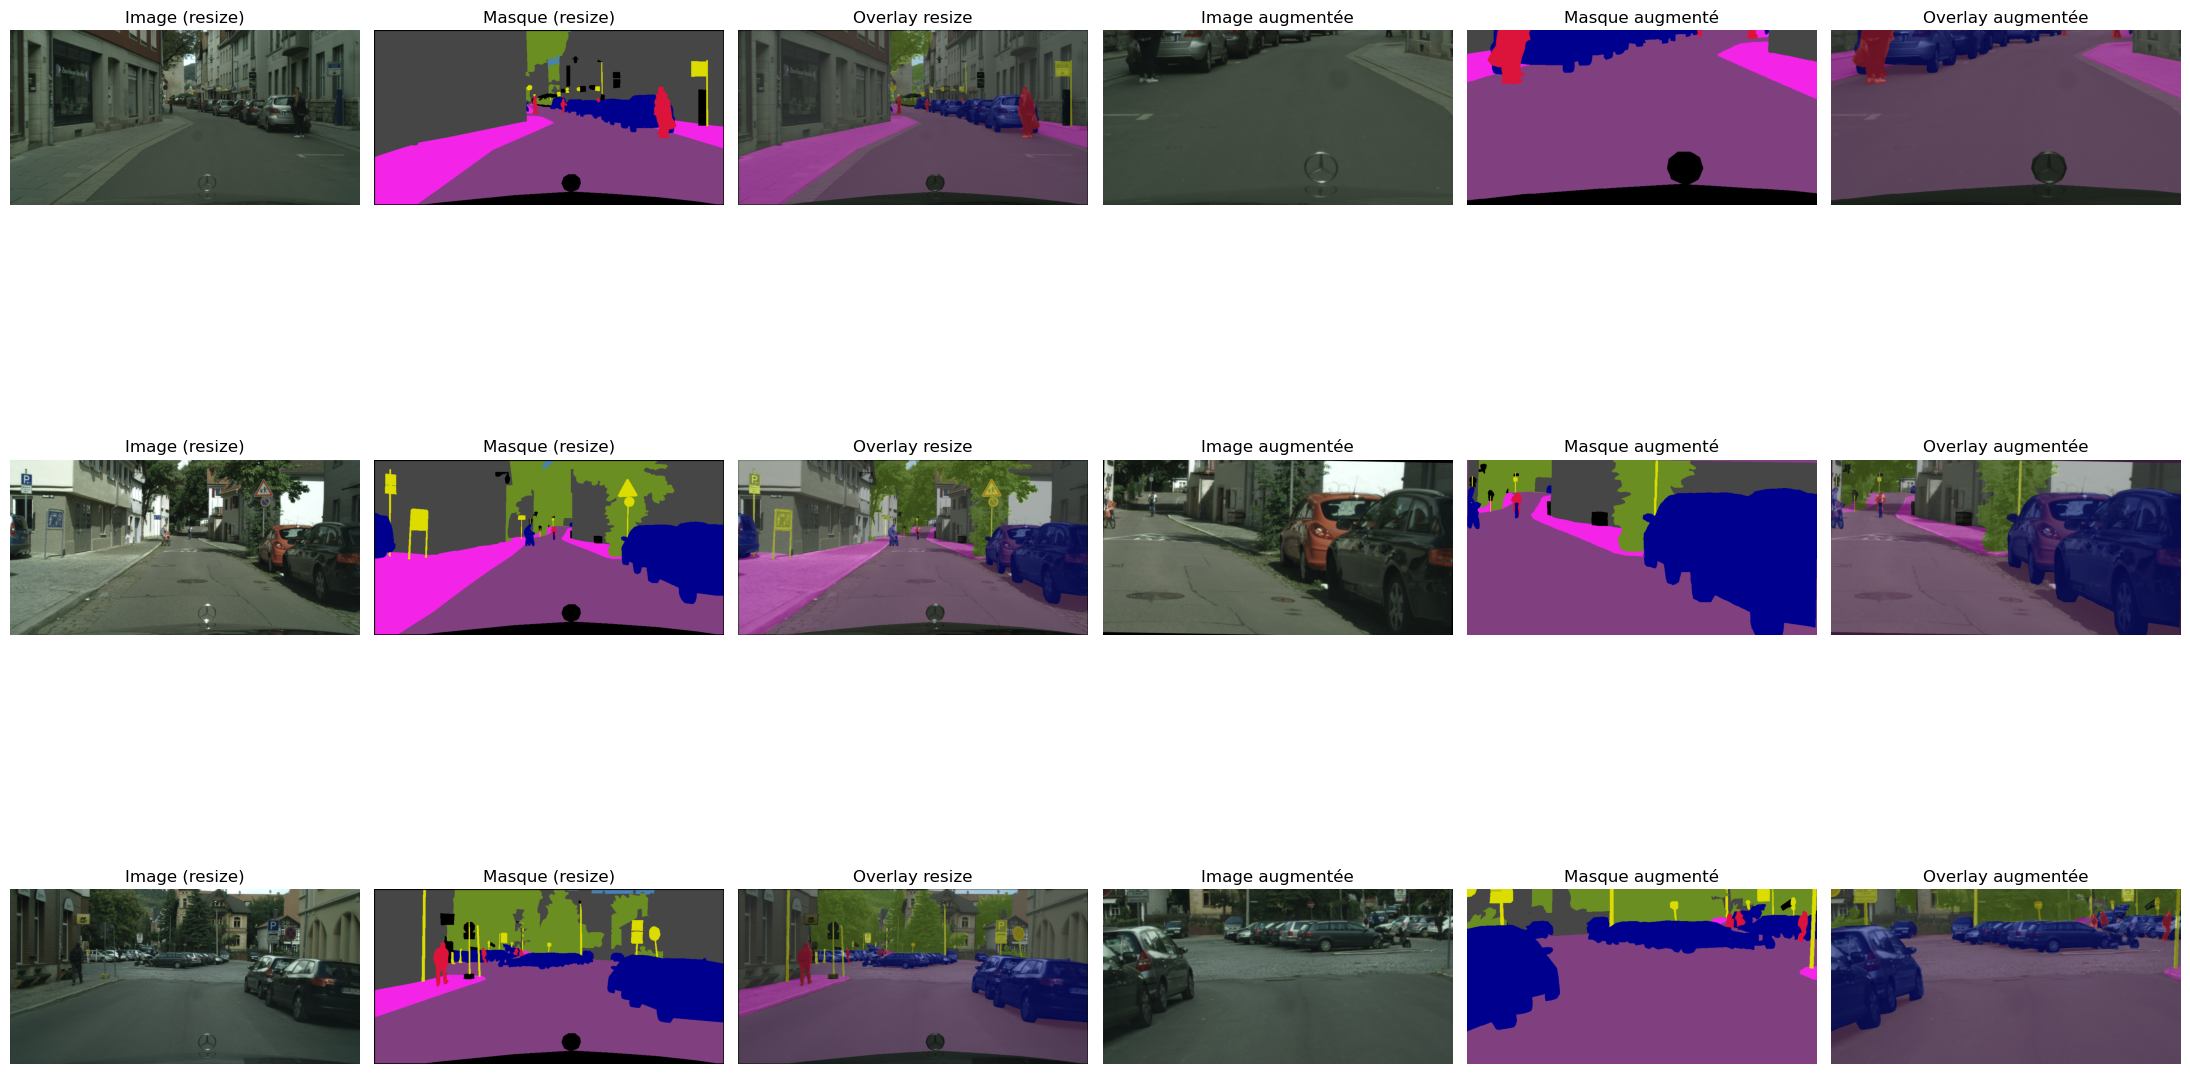

In [12]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

from scripts.config import AugmentConfig
from scripts.augment import build_augment_fn
from scripts.remap import build_cityscapes_8cls_lut, remap_labels

lut = build_cityscapes_8cls_lut(data_cfg.ignore_index)
no_aug_fn = build_augment_fn(AugmentConfig(enabled=False), data_cfg.height, data_cfg.width, data_cfg.ignore_index)
augmented_fn = build_augment_fn(aug_cfg, data_cfg.height, data_cfg.width, data_cfg.ignore_index)

def remap_to_training_ids(mask_np):
    mask_tf = tf.convert_to_tensor(mask_np, dtype=tf.int32)
    return remap_labels(mask_tf, lut).numpy()

def colorize_mask(mask_np, palette=PALETTE_8, ignore_value=data_cfg.ignore_index):
    rgb = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    for cls_id, color in palette.items():
        rgb[mask_np == cls_id] = color
    if ignore_value is not None:
        rgb[mask_np == ignore_value] = (0, 0, 0)
    return rgb

def overlay_mask(image_uint8, mask_uint8, alpha=0.45):
    colored = colorize_mask(mask_uint8)
    return np.clip((1.0 - alpha) * image_uint8 + alpha * colored, 0, 255).astype(np.uint8)

samples = pairs("train")
assert samples, "Aucun couple image/masque trouvé — vérifie le dossier data."

random.shuffle(samples)
num_rows = min(3, len(samples))
fig, axes = plt.subplots(num_rows, 6, figsize=(22, 5 * num_rows))
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

for row, (left_path, lbl_path) in enumerate(samples[:num_rows]):
    raw_img = np.array(Image.open(left_path).convert("RGB"), dtype=np.float32) / 255.0
    raw_mask = np.array(Image.open(lbl_path), dtype=np.int32)

    mask8 = remap_to_training_ids(raw_mask)

    img_tf = tf.convert_to_tensor(raw_img, dtype=tf.float32)
    mask_tf = tf.convert_to_tensor(mask8, dtype=tf.int32)

    base_img, base_mask = no_aug_fn(img_tf, mask_tf)
    aug_img, aug_mask = augmented_fn(img_tf, mask_tf)

    base_img_u8 = np.clip(base_img.numpy() * 255.0, 0, 255).astype(np.uint8)
    aug_img_u8 = np.clip(aug_img.numpy() * 255.0, 0, 255).astype(np.uint8)
    base_mask_u8 = base_mask.numpy().astype(np.uint8)
    aug_mask_u8 = aug_mask.numpy().astype(np.uint8)

    base_mask_rgb = colorize_mask(base_mask_u8)
    aug_mask_rgb = colorize_mask(aug_mask_u8)

    axes[row, 0].imshow(base_img_u8)
    axes[row, 0].set_title("Image (resize)")
    axes[row, 1].imshow(base_mask_rgb)
    axes[row, 1].set_title("Masque (resize)")
    axes[row, 2].imshow(overlay_mask(base_img_u8, base_mask_u8))
    axes[row, 2].set_title("Overlay resize")
    axes[row, 3].imshow(aug_img_u8)
    axes[row, 3].set_title("Image augmentée")
    axes[row, 4].imshow(aug_mask_rgb)
    axes[row, 4].set_title("Masque augmenté")
    axes[row, 5].imshow(overlay_mask(aug_img_u8, aug_mask_u8))
    axes[row, 5].set_title("Overlay augmentée")

    for ax in axes[row]:
        ax.axis("off")

plt.tight_layout()
plt.show()


In [13]:
# Entraînement
train("deeplab_resnet50", data_cfg, train_cfg, aug_cfg)


TF 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[info] train: 2975 pairs | missing: 0
ex: ../data/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png -> ../data/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
[info] val: 500 pairs | missing: 0
ex: ../data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png -> ../data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png
probe -> x:(2, 512, 1024, 3) <dtype: 'float32'> | y:(2, 512, 1024) <dtype: 'int32'> | w:(2, 512, 1024) <dtype: 'float32'>
Epoch 1/60


I0000 00:00:1759568573.655888 2160319 cuda_dnn.cc:529] Loaded cuDNN version 90501


25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 768ms/step - loss: 1.7258 - masked_mIoU: 0.1554 - pix_acc: 0.4021 - val_loss: 1.8059 - val_masked_mIoU: 0.0249 - val_pix_acc: 0.1855
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 736ms/step - loss: 0.8043 - masked_mIoU: 0.3619 - pix_acc: 0.7281 - val_loss: 1.7997 - val_masked_mIoU: 0.0845 - val_pix_acc: 0.3639
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 669ms/step - loss: 0.6174 - masked_mIoU: 0.5119 - pix_acc: 0.7933 - val_loss: 1.7734 - val_masked_mIoU: 0.0613 - val_pix_acc: 0.4901
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 657ms/step - loss: 0.6250 - masked_mIoU: 0.4732 - pix_acc: 0.7876 - val_loss: 1.7570 - val_masked_mIoU: 0.0754 - val_pix_acc: 0.5078
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 693ms/step - loss: 0.4545 - masked_mIoU: 0.5724 - pix_acc: 0.8474 - val_loss: 1.7367 - val_masked_mIoU: 0.0859 - val_pix_acc: 0.5227
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 679ms/step - loss: 0.4298 - masked_mIoU: 0.5908 - pix_acc: 0.8501 - val_loss: 1.7131 - val_mas

2025/10/04 11:09:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 11:09:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/10/04 11:09:12 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmphkm3xo7l/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
2025/10/04 11:09:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLflow run ended.
